In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

In [156]:
filename = "data/cleaned_data.csv"
df = pd.read_csv(filename)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43800 non-null  int64  
 1   amount_tsh         43800 non-null  float64
 2   gps_height         43800 non-null  int64  
 3   installer          43800 non-null  object 
 4   longitude          43800 non-null  float64
 5   latitude           43800 non-null  float64
 6   basin              43800 non-null  object 
 7   region             43800 non-null  object 
 8   region_code        43800 non-null  int64  
 9   district_code      43800 non-null  int64  
 10  population         43800 non-null  int64  
 11  construction_year  43800 non-null  int64  
 12  extraction_type    43800 non-null  object 
 13  payment_type       43800 non-null  object 
 14  quantity           43800 non-null  object 
 15  source             43800 non-null  object 
 16  waterpoint_type    438

We need to select the columns we want to use for the modelling part.
This selection process going to be an iterative process.


In [158]:
feat_cols = ["amount_tsh", "gps_height", "longitude", "latitude", "population", "construction_year", "extraction_type", "payment_type", "quantity", "source", "waterpoint_type"]
feat_df = df[feat_cols]

## Create Pipeline

In [159]:
numerical_cols = feat_df.select_dtypes('number').columns
categorical_cols = pd.Index(np.setdiff1d(feat_df.columns, numerical_cols))

numerical_pipe = Pipeline([
    ('scaler', StandardScaler())])

categorical_pipe = Pipeline([(
    'encoder', OneHotEncoder(handle_unknown='error'))])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, numerical_cols),
    ('cat', categorical_pipe, categorical_cols)
    ])

pipe = Pipeline([('preprocessors', preprocessors), ('model', RandomForestClassifier())])

### Divide into Train and test data

In [160]:
X_train, X_test, y_train, y_test = train_test_split(feat_df, df["status_group"], test_size=0.2, random_state=42)

## Gridsearch with 4-fold cross validation

In [161]:
parameters = {'model__n_estimators': (100,300, 400),'model__max_depth': (5,10, 15 ,20)}
model = GridSearchCV(pipe, parameters, cv=4)
model.fit(X_train,y_train)

['./model_pipe.joblib']

## Plot gridsearch results (accuracy and confusion matrix)

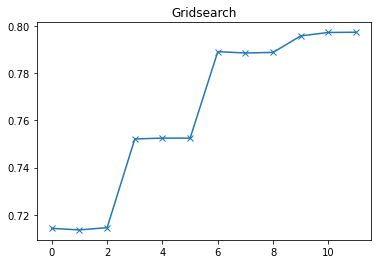

Best hyperparameter settings: {'model__max_depth': 20, 'model__n_estimators': 400}
0.8111872146118722


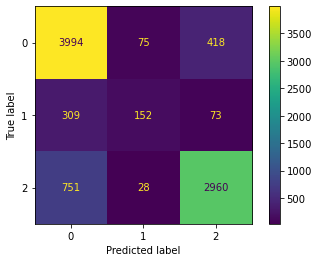

In [164]:
plt.plot(np.arange(model.cv_results_.get('mean_test_score').size), model.cv_results_.get('mean_test_score'), marker="x")
plt.title("Gridsearch")
plt.show()
print('Best hyperparameter settings: {}'.format(model.best_params_))

preds = model.predict(X_test)

print(accuracy_score(y_test, preds))
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

Save model

In [ ]:
joblib.dump(model, "./model_pipe.joblib")